<a href="https://colab.research.google.com/github/krisivarga/deep_learning_HW_big/blob/Kristof_solve/LSTM_Text_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#download file from web

import requests, zipfile, io, os

zip_file_url = "http://groups.di.unipi.it/~gulli/newsspace200.xml.bz"

filename = zip_file_url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(zip_file_url)
    f.write(r.content)

In [2]:
#create data folder, decompress data

import bz2,shutil

dirName = 'data'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
    
    
with bz2.BZ2File("newsspace200.xml.bz") as fr, open("./data/input.xml","wb") as fw:
    shutil.copyfileobj(fr,fw)

Directory  data  Created 


In [3]:
import xml.etree.ElementTree as ET

tree = ET.parse("./data/input.xml")
root = tree.getroot()

titles = []
categories = []
descriptions = []
sources = []


for title in tree.findall('title'):
    titles.append(title.text)
    
for category in tree.findall('category'):
        categories.append(category.text)

for description in tree.findall('description'):
    descriptions.append(description.text)

for source in tree.findall('source'):
    sources.append(source.text)


In [4]:
import numpy as np

In [5]:
titles = np.array(titles).T
categories = np.array(categories).T
descriptions = np.array(descriptions).T
sources = np.array(sources).T

In [6]:
data = np.dstack((sources,titles,descriptions,categories)).reshape(len(titles),4)

In [7]:
data.shape

(496835, 4)

In [8]:
import pandas as pd

df = pd.DataFrame(data)
df.columns = ['source','title', 'desc', 'cat']

In [9]:
print(f"Total unique categories are: {len(df['cat'].value_counts())}")
print(f"Count of occurance of each category:")
df['cat'].value_counts()

Total unique categories are: 17
Count of occurance of each category:


World                                                                                                                                                                                       81456
Entertainment                                                                                                                                                                               70892
Sports                                                                                                                                                                                      62163
Business                                                                                                                                                                                    56656
Top Stories                                                                                                                                                                                 56045
Sci/Tech                      

In [10]:
selected_cats = df['cat'].value_counts()[:5].index.tolist()
print(selected_cats)

df_selected = df.loc[df['cat'].isin(selected_cats)]

print(df_selected)

['World', 'Entertainment', 'Sports', 'Business', 'Top Stories']
                       source  ...       cat
0              Yahoo Business  ...  Business
1              Yahoo Business  ...  Business
2              Yahoo Business  ...  Business
3              Yahoo Business  ...  Business
4              Yahoo Business  ...  Business
...                       ...  ...       ...
496829  New York Times sports  ...    Sports
496830         BBC News world  ...     World
496831  New York Times sports  ...    Sports
496832         BBC News world  ...     World
496833  New York Times sports  ...    Sports

[327212 rows x 4 columns]


In [11]:
print(f"Total unique categories are: {len(df_selected['cat'].value_counts())}")
print(f"Count of occurance of each category:")
df_selected['cat'].value_counts()

Total unique categories are: 5
Count of occurance of each category:


World            81456
Entertainment    70892
Sports           62163
Business         56656
Top Stories      56045
Name: cat, dtype: int64

In [12]:
df_selected.isnull().sum()

source       0
title        0
desc      2415
cat          0
dtype: int64

In [13]:
df_selected = df_selected.dropna()

In [14]:
df_selected.isnull().sum()

source    0
title     0
desc      0
cat       0
dtype: int64

In [15]:
# Check of spaces in column headline - using enumerate
spaces = []
for i, x in enumerate(df_selected['title']):
    if type(x) == str:
        if x.isspace():
            spaces.append(i)
        
print(len(spaces), 'spaces in index: ', spaces)

0 spaces in index:  []


In [16]:
# Check of spaces in column short desc - using itertuples
blanks = []  # start with an empty list

for i,sou,tit,desc,cat in df_selected.itertuples():  # iterate over the DataFrame
    if type(desc)==str:            # avoid NaN values
        if desc.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


Although it is part of the database, we are not going to use the 'source' field. When we print the value_counts for that field joined with the categories, it's obvious that the category can be found in the 'source' most of the time, which defeats the point of this homework.

In [17]:
print(df_selected['source'].value_counts())
print(df_selected.value_counts(subset=['source','cat'])[:30])
print(df_selected.value_counts(subset=['source','cat'])[100:130])

Reuters              15935
Yahoo World          11193
RedNova general       7855
Reuters Business      6897
Yahoo Sports          6850
                     ...  
PopMatters               1
hockeyjournal.com        1
Montclair Times          1
Daily Independent        1
WNUR Sports              1
Name: source, Length: 3053, dtype: int64
source                      cat          
Yahoo World                 World            11193
RedNova general             World             7855
Reuters Business            Business          6897
Yahoo Sports                Sports            6850
Yahoo Entertainment         Entertainment     6741
Reuters World               World             6106
BBC News world              World             6038
Yahoo Politics              World             4586
New York Times sports       Sports            4361
Reuters                     Top Stories       3710
                            Business          3659
                            Entertainment     3547
Forbes  

Next, we define tokenization and vocabulary building. We're using the WordPiece based BERT tokenizer from huggingface.co. We also tried the SentencePie based XLNetTokenizer, but the results weren't as good as with the BERT tokenizer. The methods that are defined here will be applied to every line of the dataframe.  
  
We decided on one method, which tokenizes the title and the description and after that, it removes the tokens that contain non-alphabet characters. We do this because some descriptions contain obviously unwanted characters, like '\\' (and as we can later see from the vocabulary "39" exists more than 149000 times in the text). We also remove any token that is less than 3 characters. We build the vocabualry from these tokens.  
    
The other method uses the encode_plus function which automatically encodes the tokens too. In the function parameters we set the maximum length to 512, set the padding to extend to the max length, added special tokens and didn't take the attention mask. Depending on what modles we use, we may later need to change those settings (for example if we use BERT or XLNet models). We created a vocabulary based on the tokens too.  
  
The vocabularies can contain data multiple times, because we can see the number of appearance of tokens in the text that way if we use the value_counts function.

In [18]:
!pip install sentencepiece
!pip install transformers
from transformers import XLNetTokenizer
from transformers import BertTokenizer
import re

regex = re.compile('^[a-zA-Z]{3,}$')

xltokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

btokenizer = BertTokenizer.from_pretrained("bert-base-uncased")



     |████████████████████████████████| 1.2 MB 5.8 MB/s 
     |████████████████████████████████| 3.3 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 35.6 MB/s 
     |████████████████████████████████| 61 kB 579 kB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
def tr(bt,reg,title,sz):
  a = bt.tokenize(title + " " + sz)
  r = []
  for s in a:
    if reg.match(s) is not None:     
      r.append(s)      
  return r

df_selected['berttoken'] = df_selected.apply(lambda row: tr(btokenizer, regex, str(row['title']), str(row['desc'])), axis=1)
df_selected

,source,title,desc,cat,berttoken
0,Yahoo Business,Wall St. Pullback Reflects Tech Blowout (Reuters),"Reuters - Wall Street's long-playing drama,\""W...",Business,"[wall, pull, reflects, tech, blow, reuters, re..."
1,Yahoo Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,"[wall, bears, claw, back, into, the, black, re..."
2,Yahoo Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business,"[carly, looks, toward, commercial, aerospace, ..."
3,Yahoo Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business,"[oil, and, economy, cloud, stocks, outlook, re..."
4,Yahoo Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business,"[iraq, halt, oil, exports, from, main, souther..."
...,...,...,...,...,...
496829,New York Times sports,High on priority list: Home improvement,Doc Rivers knows any postseason plans hinge on...,Sports,"[high, priority, list, home, improvement, doc,..."
496830,BBC News world,Compromise seals climate meeting,A climate conference overcomes last-minute obj...,World,"[compromise, seals, climate, meeting, climate,..."
496831,New York Times sports,Eisley enjoying his point of view,Howard Eisley has fond memories of Boston. He ...,Sports,"[enjoying, his, point, view, howard, has, fond..."
496832,BBC News world,Iraqi judges quiz 'Chemical Ali',Ali Hassan al-Majid - widely known as Chemical...,World,"[iraqi, judges, quiz, chemical, ali, ali, hass..."


In [20]:
def bertenc(bt,title,sz):
  text_to_encode = title + " " + sz
  a = bt.encode_plus(
            text_to_encode, 
            max_length= 64, 
            add_special_tokens=True,
            return_token_type_ids=False, 
            padding="max_length",
            truncation = True,
            return_attention_mask=False
        )
  ids = a['input_ids']  
  return ids

df_selected['bertencodeplus'] = df_selected.apply(lambda row: bertenc(btokenizer, str(row['title']), str(row['desc'])), axis=1)

df_selected

,source,title,desc,cat,berttoken,bertencodeplus
0,Yahoo Business,Wall St. Pullback Reflects Tech Blowout (Reuters),"Reuters - Wall Street's long-playing drama,\""W...",Business,"[wall, pull, reflects, tech, blow, reuters, re...","[101, 2813, 2358, 1012, 4139, 5963, 11138, 662..."
1,Yahoo Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,"[wall, bears, claw, back, into, the, black, re...","[101, 2813, 2358, 1012, 6468, 15020, 2067, 204..."
2,Yahoo Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business,"[carly, looks, toward, commercial, aerospace, ...","[101, 18431, 2571, 3504, 2646, 3293, 13395, 10..."
3,Yahoo Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business,"[oil, and, economy, cloud, stocks, outlook, re...","[101, 3514, 1998, 4610, 6112, 15768, 1005, 176..."
4,Yahoo Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business,"[iraq, halt, oil, exports, from, main, souther...","[101, 5712, 9190, 2015, 3514, 14338, 2013, 236..."
...,...,...,...,...,...,...
496829,New York Times sports,High on priority list: Home improvement,Doc Rivers knows any postseason plans hinge on...,Sports,"[high, priority, list, home, improvement, doc,...","[101, 2152, 2006, 9470, 2862, 1024, 2188, 7620..."
496830,BBC News world,Compromise seals climate meeting,A climate conference overcomes last-minute obj...,World,"[compromise, seals, climate, meeting, climate,...","[101, 12014, 13945, 4785, 3116, 1037, 4785, 30..."
496831,New York Times sports,Eisley enjoying his point of view,Howard Eisley has fond memories of Boston. He ...,Sports,"[enjoying, his, point, view, howard, has, fond...","[101, 1041, 2483, 3051, 9107, 2010, 2391, 1997..."
496832,BBC News world,Iraqi judges quiz 'Chemical Ali',Ali Hassan al-Majid - widely known as Chemical...,World,"[iraqi, judges, quiz, chemical, ali, ali, hass...","[101, 8956, 6794, 19461, 1005, 5072, 4862, 100..."


Here we can see the result of the encoded vocabulary with the token values.

In [21]:
bertencidvoc_dict = {}
bertvoc_dict = {}
def dict_creater(arr):
  for a in arr:
    if a != 0:
      if a in bertencidvoc_dict:
        count = bertencidvoc_dict[a] + 1
        bertencidvoc_dict.update({a:count})
      else:
        bertencidvoc_dict.update({a:1})
  return

def dict_creater2(arr):
  for a in arr:
    if a != 0:
      if a in bertvoc_dict:
        count = bertvoc_dict[a] + 1
        bertvoc_dict.update({a:count})
      else:
        bertvoc_dict.update({a:1})
  return

df_selected.apply(lambda row: dict_creater(row['bertencodeplus']), axis=1)

df_selected.apply(lambda row: dict_creater2(row['berttoken']), axis=1)

bertvoc_dict

{'wall': 3388,
 'pull': 1820,
 'reflects': 134,
 'tech': 1682,
 'blow': 1375,
 'reuters': 39445,
 'street': 3845,
 'long': 6772,
 'playing': 1529,
 'drama': 900,
 'waiting': 835,
 'for': 133895,
 'google': 2773,
 'about': 17594,
 'reach': 2367,
 'its': 43224,
 'final': 8332,
 'act': 1249,
 'but': 23801,
 'stock': 4308,
 'market': 6782,
 'debut': 1434,
 'ending': 1714,
 'more': 23353,
 'nostalgia': 30,
 'event': 1675,
 'than': 17414,
 'the': 570053,
 'catalyst': 27,
 'new': 50937,
 'era': 1154,
 'bears': 783,
 'claw': 42,
 'back': 12031,
 'into': 17641,
 'black': 2809,
 'short': 2838,
 'sellers': 76,
 'band': 1291,
 'ultra': 120,
 'are': 23633,
 'seeing': 321,
 'green': 2510,
 'again': 4971,
 'carly': 126,
 'looks': 1331,
 'toward': 2296,
 'commercial': 987,
 'aerospace': 174,
 'private': 1859,
 'investment': 1591,
 'firm': 3156,
 'group': 12423,
 'which': 11381,
 'has': 51516,
 'reputation': 369,
 'making': 3040,
 'well': 3024,
 'timed': 71,
 'and': 184938,
 'occasionally': 50,
 'contr

We encoded the categories with numbers, so they're easier to work with.

In [22]:
i = 0
category_dictionary = {}
cat_rev_dict= {}
for s in selected_cats:
  category_dictionary.update({i:s})
  cat_rev_dict.update({s:i})
  i = i + 1
print(category_dictionary)

df_selected['cat_enc'] = df_selected.apply(lambda row: cat_rev_dict[str(row['cat'])] , axis=1)
df_selected

{0: 'World', 1: 'Entertainment', 2: 'Sports', 3: 'Business', 4: 'Top Stories'}


,source,title,desc,cat,berttoken,bertencodeplus,cat_enc
0,Yahoo Business,Wall St. Pullback Reflects Tech Blowout (Reuters),"Reuters - Wall Street's long-playing drama,\""W...",Business,"[wall, pull, reflects, tech, blow, reuters, re...","[101, 2813, 2358, 1012, 4139, 5963, 11138, 662...",3
1,Yahoo Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,"[wall, bears, claw, back, into, the, black, re...","[101, 2813, 2358, 1012, 6468, 15020, 2067, 204...",3
2,Yahoo Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business,"[carly, looks, toward, commercial, aerospace, ...","[101, 18431, 2571, 3504, 2646, 3293, 13395, 10...",3
3,Yahoo Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business,"[oil, and, economy, cloud, stocks, outlook, re...","[101, 3514, 1998, 4610, 6112, 15768, 1005, 176...",3
4,Yahoo Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business,"[iraq, halt, oil, exports, from, main, souther...","[101, 5712, 9190, 2015, 3514, 14338, 2013, 236...",3
...,...,...,...,...,...,...,...
496829,New York Times sports,High on priority list: Home improvement,Doc Rivers knows any postseason plans hinge on...,Sports,"[high, priority, list, home, improvement, doc,...","[101, 2152, 2006, 9470, 2862, 1024, 2188, 7620...",2
496830,BBC News world,Compromise seals climate meeting,A climate conference overcomes last-minute obj...,World,"[compromise, seals, climate, meeting, climate,...","[101, 12014, 13945, 4785, 3116, 1037, 4785, 30...",0
496831,New York Times sports,Eisley enjoying his point of view,Howard Eisley has fond memories of Boston. He ...,Sports,"[enjoying, his, point, view, howard, has, fond...","[101, 1041, 2483, 3051, 9107, 2010, 2391, 1997...",2
496832,BBC News world,Iraqi judges quiz 'Chemical Ali',Ali Hassan al-Majid - widely known as Chemical...,World,"[iraqi, judges, quiz, chemical, ali, ali, hass...","[101, 8956, 6794, 19461, 1005, 5072, 4862, 100...",0


In [23]:
# Since the goal of this exercise if to identify category based on headline and short description, 
# we choose to merge them, as the vectorizer functions can't process multiple columns

#df_selected['joined'] = df_selected.apply(lambda row: " ".join(row['berttoken']) , axis=1)
X = np.array(df_selected["bertencodeplus"].values.tolist())
#X = df_selected['bertencodeplus'].to_numpy()
y = df_selected['cat_enc'].to_numpy()

In [24]:
X

array([[  101,  2813,  2358, ...,  3690,  1012,   102],
       [  101,  2813,  2358, ...,     0,     0,     0],
       [  101, 18431,  2571, ...,     0,     0,     0],
       ...,
       [  101,  1041,  2483, ...,     0,     0,     0],
       [  101,  8956,  6794, ...,     0,     0,     0],
       [  101, 16996,  2131, ...,     0,     0,     0]])

In [25]:
y

array([3, 3, 3, ..., 2, 0, 2])

In [26]:
#X.describe()
len(X[0])


64

In [27]:
from sklearn.model_selection import train_test_split

# Split the data into 70-30 i.e. test size of 30% to check the accuracy of the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle = True)

#Let's check the shape of the splitted data
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (227357, 64)
Testing Data Shape: (48720, 64)


In [28]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, SpatialDropout1D, Conv1D, MaxPooling1D

In [29]:
Y_train = to_categorical(y_train, num_classes=5, dtype='float32')
Y_test = to_categorical(y_test, num_classes=5, dtype='float32')
Y_valid = to_categorical(y_valid, num_classes=5, dtype='float32')

In [30]:
def build_model(hp):  
  model = tensorflow.keras.Sequential([
    keras.layers.Embedding(
        input_dim = len(bertvoc_dict),
        output_dim = hp.Int('embedding_output_dim', min_value=128, max_value=256, step=32),
        input_length = 64
    ),
    tensorflow.keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=2, max_value=16, step=2),
        kernel_size=hp.Int('conv_1_kernel', min_value=4, max_value=16, step=4),
        padding='same',
        activation='relu'
    ),
    tensorflow.keras.layers.Dropout(
        rate = hp.Float('dropout_1', min_value=0.1, max_value=0.7, step=0.1)
    ),
    tensorflow.keras.layers.LSTM(
        units=hp.Int('lstm_1_units', min_value=96, max_value=128, step=16)
    ),
    tensorflow.keras.layers.Dropout(
        rate = hp.Float('dropout_2', min_value=0.1, max_value=0.7, step=0.1)
    ),
    tensorflow.keras.layers.Dense(
        units = hp.Int('dense_2_units', min_value=32, max_value=96, step=32),
        activation = 'relu'
    ),
    tensorflow.keras.layers.Dense(
        units = 5,
        activation = 'softmax'
    )
  ])

  model.compile(optimizer=tensorflow.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [33]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [31]:
i = 0

In [34]:
from keras_tuner.tuners import Hyperband
i = i + 1
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='output_' + str(i),
    project_name='LSTM_CONV_TXT_CLASS_' + str(i))

In [35]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
embedding_output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': None}
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': None}
conv_1_kernel (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 4, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
lstm_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 96, 'max_value': 128, 'step': 16, 'sampling': None}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
dense_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [ ]:
tuner.search(X_train, Y_train, epochs=10, validation_data=(X_valid,Y_valid))

Trial 26 Complete [00h 08m 26s]
val_accuracy: 0.6697044372558594

Best val_accuracy So Far: 0.6798029541969299
Total elapsed time: 01h 48m 45s

Search: Running Trial #27

Hyperparameter    |Value             |Best Value So Far 
embedding_outpu...|224               |224               
conv_1_filter     |4                 |10                
dropout_1         |0.6               |0.3               
lstm_1_units      |112               |112               
dropout_2         |0.5               |0.1               
dense_2_units     |64                |64                
learning_rate     |0.01              |0.001             
tuner/epochs      |10                |10                
tuner/initial_e...|0                 |4                 
tuner/bracket     |0                 |2                 
tuner/round       |0                 |2                 

Epoch 1/10
9135/9135 [==============================] - 81s 9ms/step - loss: 1.3110 - accuracy: 0.4441 - val_loss: 1.6087 - val_accuracy: 0.3095

KeyboardInterrupt: ignored

In [38]:
best_model = keras.models.load_model("best_LSTM_CONV1D_model.h5")

In [39]:
best_model.evaluate(X_test,Y_test)

1523/1523 [==============================] - 23s 9ms/step - loss: 0.7742 - accuracy: 0.6713


[0.7741839289665222, 0.6713054180145264]

In [93]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [70]:
preds = best_model.predict(X_test)
y_pred=np.argmax(preds,axis=1)

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.89      0.75     12259
           1       0.54      0.49      0.52     10610
           2       0.76      0.97      0.85      9277
           3       0.72      0.92      0.81      8214
           4       0.30      0.00      0.00      8360

    accuracy                           0.67     48720
   macro avg       0.59      0.65      0.59     48720
weighted avg       0.60      0.67      0.60     48720



In [89]:
conf_mat = confusion_matrix(y_test, y_pred)
target_names = ['World','Entertainment','Sports','Business','Top Stories']

In [90]:
conf_mat_df = pd.DataFrame(conf_mat,
                     index = target_names, 
                     columns = target_names)

In [99]:
conf_mat_df

,World,Entertainment,Sports,Business,Top Stories
World,10885,683,188,501,2
Entertainment,2808,5241,1309,1249,3
Sports,103,102,9010,62,0
Business,236,336,73,7567,2
Top Stories,2622,3307,1337,1091,3


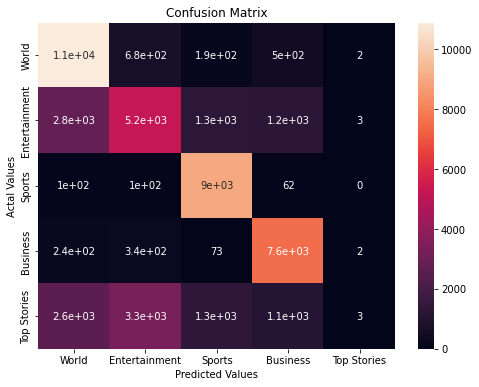

In [102]:
#Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [47]:
test_articles = df_selected.sample(10)

In [48]:
test_articles

,source,title,desc,cat,berttoken,bertencodeplus,cat_enc
128999,Denver Post,HBO #39;s quot;Angels quot; heavy favorites a...,Garry Shandling brings his insecurities and la...,Entertainment,"[hbo, quo, angels, quo, heavy, favorites, emmy...","[101, 14633, 1001, 4464, 1025, 1055, 22035, 21...",1
466673,Fox Sports,"Woods, Montgomerie share lead",TIGER Woods carded a five-under 66 to share th...,Top Stories,"[woods, mont, share, lead, tiger, woods, card,...","[101, 5249, 1010, 18318, 3995, 28677, 3745, 25...",4
311326,Today (Singapore),Scientists search for more human species,SYDNEY - Following the spectacular discovery o...,Top Stories,"[scientists, search, for, more, human, species...","[101, 6529, 3945, 2005, 2062, 2529, 2427, 3994...",4
150578,Reuters,Jaguar boss confident sale of team will happen,Ford have had strong interest in their Jaguar ...,Sports,"[jaguar, boss, confident, sale, team, will, ha...","[101, 16490, 5795, 9657, 5096, 1997, 2136, 209...",2
42194,Yahoo News,"Vioxx Faces Challenges from Insurers, Lawyers",Merck amp; Co. faces a dual threat from healt...,Business,"[faces, challenges, from, ins, lawyers, mer, a...","[101, 6819, 11636, 2595, 5344, 7860, 2013, 160...",3
132438,Semiconductor Business News,Hynix accused of \$1.7 billion 1999 accounting...,"SEOUL, South Korea - Hynix Semiconductor Inc.,...",Business,"[accused, billion, accounting, fraud, seoul, s...","[101, 1044, 6038, 7646, 5496, 1997, 1032, 1002...",3
311763,BBC News world,Kofi Annan 'vetoed UN sex claim',UN refugee chief Ruud Lubbers was cleared of s...,World,"[anna, veto, sex, claim, refugee, chief, was, ...","[101, 12849, 8873, 4698, 2078, 1005, 22102, 20...",0
197719,CNN International,Italy deports migrants to Libya,Italy has come under fire for sending would-be...,World,"[italy, migrants, libya, italy, has, come, und...","[101, 3304, 2139, 25378, 16836, 2000, 12917, 3...",0
159713,Boston Globe,Muslims travel to Iraq seeking British hostage...,A two-man delegation from Britain #39;s bigges...,Top Stories,"[muslims, travel, iraq, seeking, british, host...","[101, 7486, 3604, 2000, 5712, 6224, 2329, 1344...",4
490428,Aversion,ODB #39;s Death Ruled Overdose,Old Dirty Bastard #39;s death outside a New Yo...,Top Stories,"[death, ruled, overdose, old, dirty, bastard, ...","[101, 1051, 18939, 1001, 4464, 1025, 1055, 233...",4


In [49]:
test_articles_x = np.array(test_articles["bertencodeplus"].values.tolist())

In [51]:
test_articles_y = test_articles['cat_enc'].to_numpy()

In [54]:
test_articles_preds = best_model.predict(test_articles_x)

In [56]:
classes_x=np.argmax(test_articles_preds,axis=1)

In [57]:
classes_x

array([1, 2, 0, 2, 3, 3, 0, 0, 0, 1])

In [58]:
category_dictionary

{0: 'World', 1: 'Entertainment', 2: 'Sports', 3: 'Business', 4: 'Top Stories'}

In [61]:
examples = test_articles[["title", "desc", "cat"]]

In [63]:
examples["preds"] = classes_x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
examples["preds"] = examples["preds"].apply(lambda x: category_dictionary.get(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
examples

,title,desc,cat,preds
128999,HBO #39;s quot;Angels quot; heavy favorites a...,Garry Shandling brings his insecurities and la...,Entertainment,Entertainment
466673,"Woods, Montgomerie share lead",TIGER Woods carded a five-under 66 to share th...,Top Stories,Sports
311326,Scientists search for more human species,SYDNEY - Following the spectacular discovery o...,Top Stories,World
150578,Jaguar boss confident sale of team will happen,Ford have had strong interest in their Jaguar ...,Sports,Sports
42194,"Vioxx Faces Challenges from Insurers, Lawyers",Merck amp; Co. faces a dual threat from healt...,Business,Business
132438,Hynix accused of \$1.7 billion 1999 accounting...,"SEOUL, South Korea - Hynix Semiconductor Inc.,...",Business,Business
311763,Kofi Annan 'vetoed UN sex claim',UN refugee chief Ruud Lubbers was cleared of s...,World,World
197719,Italy deports migrants to Libya,Italy has come under fire for sending would-be...,World,World
159713,Muslims travel to Iraq seeking British hostage...,A two-man delegation from Britain #39;s bigges...,Top Stories,World
490428,ODB #39;s Death Ruled Overdose,Old Dirty Bastard #39;s death outside a New Yo...,Top Stories,Entertainment


In [68]:
examples.to_excel("examples.xlsx")